# More examples of useful tools for Solar System Objects

Let's explore more tools, with the following two small exercices


### Ex1. Map the Solar System

We have seen in the previous notebook how to access the ephemerides of objects. We did it for a couple of objects. But what if we want to know the position of **all** of them? Requesting thousands of time an ephemeris may not be the most efficient solution.

Let's use the [**SkyBoT 3D**](http://vo.imcce.fr/webservices/skybot3d/) service of the [IMCCE](https://www.imcce.fr) for that:
- Query SkyBot 3D for Apollo 
- Plot their position in ecliptic cartesian (x,y) coordinates

*Pro tip:* many services have keywords limiting the size of the answer (here the <kbd>limit</kbd> parameter). Use them when developping your code (e.g., limiting to 10, 50, or 100 objects per query) to avoid saturating services.



In [31]:
# Code here



### Ex2. Get ready for LSST!

The [Legacy Survey of Space and Time](https://www.lsst.org/) of the Vera C. Rubin observatory will run for a decade, starting in 2025, and is expected to discover several millions of small bodies of the Solar System (asteroids, comets, KBOs, ...). LSST will stream a flux of alerts in near real-time, and [*brokers*](https://www.lsst.org/scientists/alert-brokers) have been set up to process and release this tremendous data set.
Let's use one of them to get data on an asteroid (obtained by [ZTF](https://www.ztf.caltech.edu/), a precursor of LSST) and use sbpy to check the photometric behavior.

- Retrieve the observations of asteroid number 8253 from [FINK](https://fink-portal.org/)
- Using the heliocentric and range to observer, reduced the apparent magnitude to unit distances
- Plot the reduced magnitude for each filter (*g* and *r*) as function of the phase angle
- Use [sbpy](https://sbpy.org/) to overplot the expected HG phase function, using (H,G) = (15.4,0.15)

In [ ]:
# Code here



<br><br><br><br><br><br><br><br>
As in previous notebook, examples of solutions are presented below **BUT** the best (only?) way to learn is to **try yourself**!
<br><br><br><br><br><br><br><br>


Anyway, scroll a bit more and follow the white rabbit...
<br><br><br><br><br><br><br><br>

In [1]:
import io
import requests
import json

import rocks
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.projections

### Ex1. Map the Solar System

Reminder
- Query [SkyBot 3D](http://vo.imcce.fr/webservices/skybot3d/) for Apollo 
- Plot their position in ecliptic cartesian (x,y) coordinates

We need first to look at the documentation. There are several access points, for comets, asteroids... so let's use <kbd>getAster</kbd> to retrieve NEAs. Then, it is only a matter of setting a dictionary with the parameters for <kbd>requests</kbd> to do it for us!

In [32]:
# Service URL
url = "http://vo.imcce.fr/webservices/skybot3d/getAster_query.php?"


# Query parameters
params = {
    "-ep": "2024-01-01",
    "-class": "NEA>Apollo",
    "-limit": "1000",
    "-mime": "json",
    "-coord": "rectangular",
    "-getFile": 1,
    "-from": "Student_at_Les_Houches",
}

# Query the service
try:
    r = requests.post(url, params=params, timeout=2000)
except requests.exceptions.ReadTimeout:
    print("Request timed out")

# Convert the json results into a python dictionary
result = json.loads(r.content)

# Get results in a pandas DataFrame: the json does not contain the column names, but the documentation does
ssos = pd.DataFrame(result["asteroids"])
ssos.columns = [
    "id",
    "px",
    "py",
    "pz",
    "vx",
    "vy",
    "vz",
    "H",
    "G",
    "class",
    "name",
    "diameter",
    "sso_type",
]

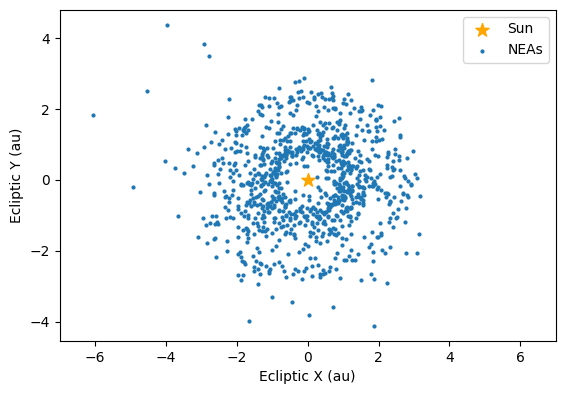

In [33]:
# Plot elevation curves
fig, ax = plt.subplots()

# The Sun!
ax.scatter(0, 0, marker="*", s=100, color="orange", label="Sun")

# --------------------------------------------------------------------------------
# Plot the trajectory
ax.scatter(ssos["px"], ssos["py"], label="NEAs", s=4)

# --------------------------------------------------------------------------------
# Set up axes
ax.set_xlabel("Ecliptic X (au)")
ax.set_ylabel("Ecliptic Y (au)")
ax.set_aspect("equal")
ax.set_xlim(-7, 7)
ax.legend(loc="upper right")

Voila!

This can be used to create nice viewgraphs of the inner or outer Solar System.

### Ex2. Get ready for LSST!

Reminder:
- Retrieve the observations of asteroid number 8253 from [FINK](https://fink-portal.org/)
- Using the heliocentric and range to observer, reduced the apparent magnitude to unit distances
- Plot the reduced magnitude for each filter (*g* and *r*) as function of the phase angle
- Use [sbpy](https://sbpy.org/) to overplot the expected HG phase function, using (H,G) = (15.4,0.15)


After a look at FINK, there is a Web interface where objects (including Solar System) can be queried, but **better**! there are [**APIs**](https://fink-portal.org/api)! One is dedicated to Solar System : <kbd>Solar System objects from MPC</kbd>. 
Querying it should look like:

In [19]:
import io

# Get data from FINK API
r = requests.post(
    'https://fink-portal.org/api/v1/sso',
    json={
        'n_or_d': '8253',
        'withEphem': True,
        'output-format': 'json'
    }
)

# Format output in a DataFrame
ztf = pd.read_json(io.BytesIO(r.content))

Inspect the created DataFrame. There are a lot of columns! Good news, they are [all described](https://fink-portal.org/api/v1/columns).

Let's create a <kbd>reduced_mag</kbd> column and then plot it 

In [34]:
# Reduction to unit distance
ztf['reduced_mag'] = ztf['i:magpsf'] - 5*np.log10( ztf['Dobs'] * ztf['Dhelio'])

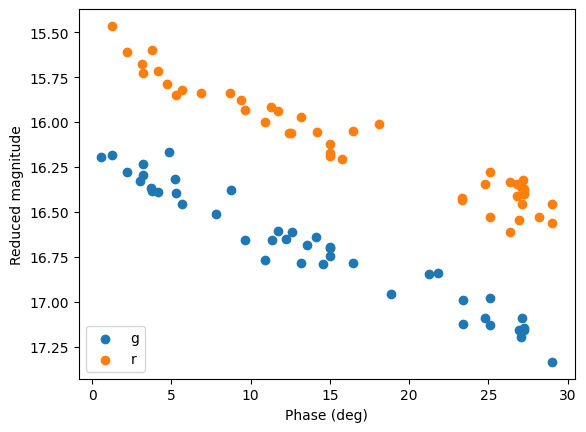

In [36]:
fig, ax = plt.subplots()

# Splitting data in two filters
filt_g = ztf['i:fid'] == 1
filt_r = ztf['i:fid'] == 2

# Plot magnitude vs phase
ax.scatter( ztf.loc[filt_g,'Phase'], ztf.loc[filt_g,'reduced_mag'], label='g')
ax.scatter( ztf.loc[filt_r,'Phase'], ztf.loc[filt_r,'reduced_mag'], label='r')

# Set up axes
ax.set_xlabel('Phase (deg)')
ax.set_ylabel('Reduced magnitude')
ax.invert_yaxis()
ax.legend(loc='lower left')


The graph shows the well-known photometry behavior as function of phase. To overplot the theoretical phase function, we need the definition of its components. These are easily available thanks to [sbpy](https://sbpy.org/), in its [<kbd>photometry</kbd>](https://sbpy.readthedocs.io/en/stable/sbpy/photometry.html#disk-integrated-phase-function-models) module:

In [39]:
from sbpy.photometry import HG

# Define the HG parameters
G = 0.15
H = 15.38

# Build a phase angle array from 0 to 30 degrees
ph = np.linspace(0, np.radians(30), num=100)

# Compute the phase function
phase_func = -2.5 * np.log10( (1 - G) * HG._hgphi(ph, 1) + G * HG._hgphi(ph, 2) )

Merci sbpy!

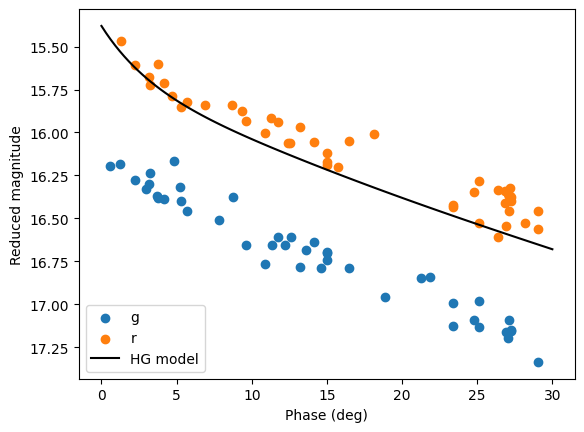

In [40]:
fig, ax = plt.subplots()

# Splitting data in two filters
filt_g = ztf['i:fid'] == 1
filt_r = ztf['i:fid'] == 2

# Plot magnitude vs phase
ax.scatter( ztf.loc[filt_g,'Phase'], ztf.loc[filt_g,'reduced_mag'], label='g')
ax.scatter( ztf.loc[filt_r,'Phase'], ztf.loc[filt_r,'reduced_mag'], label='r')

# Overplot the phase function
ax.plot(np.degrees(ph), phase_func + H, color='black', label='HG model')


# Set up axes
ax.set_xlabel('Phase (deg)')
ax.set_ylabel('Reduced magnitude')
ax.invert_yaxis()
ax.legend(loc='lower left')

Any idea why there is a vertical shift between the two filters?